# DATA WRANGLING PROJECT THREE

In [2]:
# ==============================================================================
# Step 1: Setup and Data Loading
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

In [3]:
# Setting the visual style for plots
sns.set_style("whitegrid")

In [4]:
# Loading all the datasets from CSV files
try:
    invoices_df = pd.read_csv("synthetic_invoices.csv")
    vials_df = pd.read_csv("synthetic_vials.csv")
    dispense_log_df = pd.read_csv("synthetic_dispense_log.csv")
    claims_df = pd.read_csv("synthetic_claims.csv")
    print("All CSV files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please ensure all CSV files are in the correct directory.")
    raise

All CSV files loaded successfully.


In [5]:
# ==============================================================================
# Step 2: Data Wrangling (Cleaning and Merging)
# ==============================================================================
# The 'Purchase Price' column in vials_df to be a numeric type because they have '$' in it.
vials_df['Purchase Price'] = vials_df['Purchase Price'].replace({'\\$': ''}, regex=True).astype(float)

# The separated other csv files merging into a single dataframe, comprehensive dataframe
vial_invoice_df = pd.merge(vials_df, invoices_df, on="Invoice Number", how="left")
full_df = pd.merge(vial_invoice_df, dispense_log_df, on="Vial Number", how="left")
full_df = pd.merge(full_df, claims_df, on="Dispense ID", how="left")
print("\nDataframes merged into 'full_df'.")


Dataframes merged into 'full_df'.


In [6]:
# Checking for and to handle duplicate rows
duplicates = full_df.duplicated().sum()
print(f"\nNumber of duplicate rows found: {duplicates}")
if duplicates > 0:
    full_df = full_df.drop_duplicates()
    print("Duplicates have been removed.")
else:
    print("No duplicates found.")


Number of duplicate rows found: 0
No duplicates found.


In [7]:
# Checking for and to handle missing values using the forward-fill method
print(f"\nTotal missing values before handling: {full_df.isnull().sum().sum()}")
full_df.fillna(method='ffill', inplace=True)
print("Missing values handled using forward fill.")
print(f"Total missing values after handling: {full_df.isnull().sum().sum()}")


Total missing values before handling: 42786
Missing values handled using forward fill.
Total missing values after handling: 9


C:\Users\rahul\AppData\Local\Temp\ipykernel_8304\1573965327.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df.fillna(method='ffill', inplace=True)


In [8]:
# ==============================================================================
# Step 3: Initial Analysis and Reporting
# ==============================================================================
print("\n--- Ophthalmology Drug Tracking Analysis ---")

# 1. Identified and report on unscanned vials
unscanned_vials = full_df[full_df['Unscanned'] == True]
print(f"\n## Unscanned Vials Report ({len(unscanned_vials)} found)")
if not unscanned_vials.empty:
    print("The following vials were dispensed but not scanned, leading to potential revenue loss:")
    print(unscanned_vials[['Vial Number', 'Lot Number', 'Purchase Price', 'Dispense ID', 'Patient ID', 'Date Of Dispense', 'Username']].head())


--- Ophthalmology Drug Tracking Analysis ---

## Unscanned Vials Report (875 found)
The following vials were dispensed but not scanned, leading to potential revenue loss:
   Vial Number   Lot Number  Purchase Price  Dispense ID  Patient ID  \
6   VN-0000005  LOT-8583121            50.0  DISP-010328    567386.0   
34  VN-0000025  LOT-5251569            50.0  DISP-003474    930415.0   
35  VN-0000026  LOT-8694199            50.0  DISP-003474    930415.0   
50  VN-0000038  LOT-1985938            50.0  DISP-002492    435402.0   
71  VN-0000050  LOT-8239582            50.0  DISP-007851    722927.0   

   Date Of Dispense     Username  
6        2025-05-04    jen.kirby  
34       2025-03-01  dina.dropem  
35       2025-03-01  dina.dropem  
50       2025-05-08  dina.dropem  
71       2025-06-11   sarah.benz  


In [9]:
# 2. Identified and report on denied claims
denied_claims = full_df[full_df['Denied'] == True]
print(f"\n## Denied Claims Report ({len(denied_claims)} found)")
if not denied_claims.empty:
    print("The following claims were denied by insurance:")
    print(denied_claims[['Claim ID', 'Dispense ID', 'Vial Number', 'Patient ID', 'Claim Date', 'Amount']].head())


## Denied Claims Report (561 found)
The following claims were denied by insurance:
       Claim ID  Dispense ID Vial Number  Patient ID  Claim Date  Amount
6    CLM-010328  DISP-010328  VN-0000005    567386.0  2025-09-09   92.40
50   CLM-002492  DISP-002492  VN-0000038    435402.0  2025-03-26  102.98
71   CLM-007851  DISP-007851  VN-0000050    722927.0  2025-02-22  119.08
77   CLM-000043  DISP-000043  VN-0000056    702136.0  2025-05-07   65.80
201  CLM-008965  DISP-008965  VN-0000149    406197.0  2025-07-21  124.17


In [10]:
# 3. Performed and report on profitability analysis
reimbursed_claims = full_df[(full_df['Denied'] == False) & (full_df['Amount'].notna())].copy()
reimbursed_claims['Profit'] = reimbursed_claims['Amount'] - reimbursed_claims['Purchase Price']
total_revenue = reimbursed_claims['Amount'].sum()
total_cost = reimbursed_claims['Purchase Price'].sum()
total_profit = reimbursed_claims['Profit'].sum()

print("\n## Profitability Analysis")
print(f"Total Revenue from Reimbursed Claims: ${total_revenue:,.2f}")
print(f"Total Cost of Goods Sold: ${total_cost:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")


## Profitability Analysis
Total Revenue from Reimbursed Claims: $1,980,313.37
Total Cost of Goods Sold: $759,600.00
Total Profit: $1,220,713.37



--- Generating EDA Visualizations ---


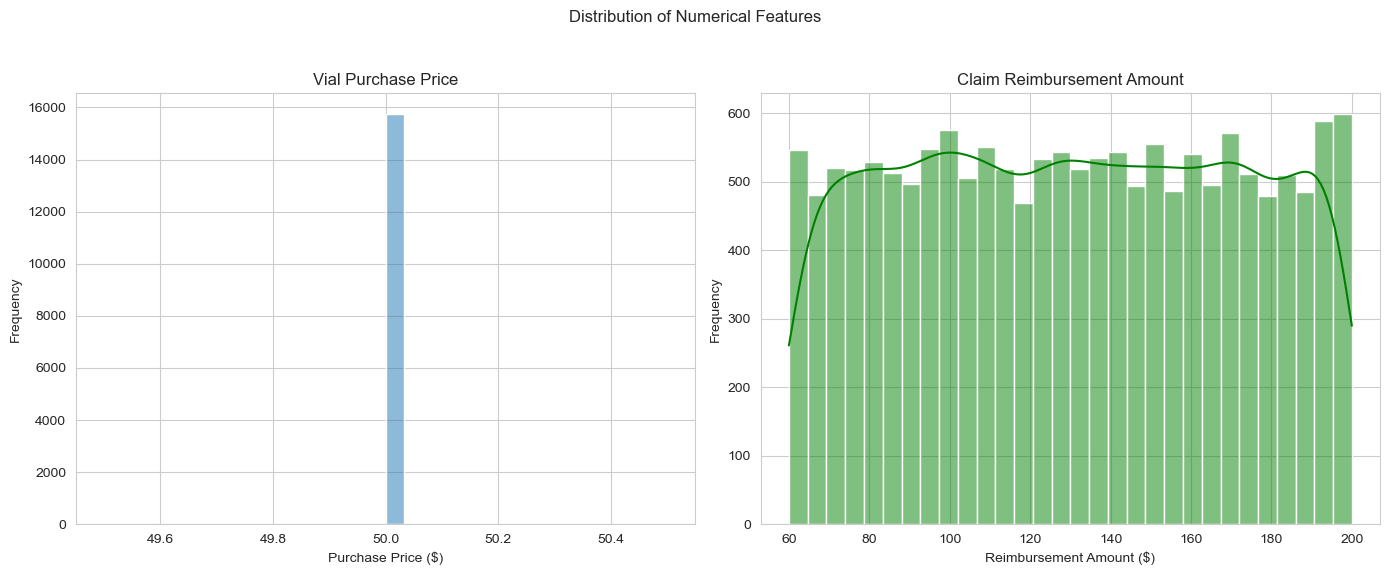

In [11]:
# ==============================================================================
# Step 4: Exploratory Data Analysis (EDA) and Visualizations
# ==============================================================================
print("\n--- Generating EDA Visualizations ---")

# Visualization 1: Distribution of Key Numerical Features
plt.figure(figsize=(14, 6))
plt.suptitle('Distribution of Numerical Features')

plt.subplot(1, 2, 1)
sns.histplot(full_df['Purchase Price'], kde=True, bins=30)
plt.title('Vial Purchase Price')
plt.xlabel('Purchase Price ($)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(full_df[full_df['Amount'].notna()]['Amount'], kde=True, bins=30, color='green')
plt.title('Claim Reimbursement Amount')
plt.xlabel('Reimbursement Amount ($)')
plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

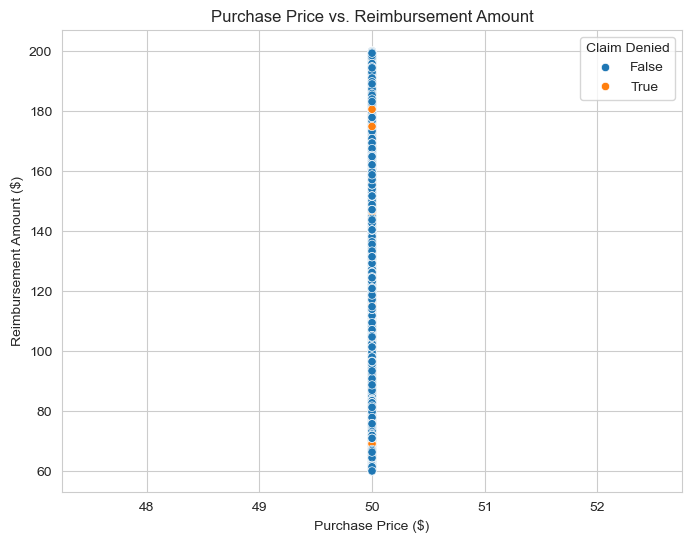

In [12]:
# Visualization 2: Relationship between Purchase Price and Reimbursement Amount
plt.figure(figsize=(8, 6))
sns.scatterplot(data=full_df, x='Purchase Price', y='Amount', hue='Denied')
plt.title('Purchase Price vs. Reimbursement Amount')
plt.xlabel('Purchase Price ($)')
plt.ylabel('Reimbursement Amount ($)')
plt.legend(title='Claim Denied')
plt.show()

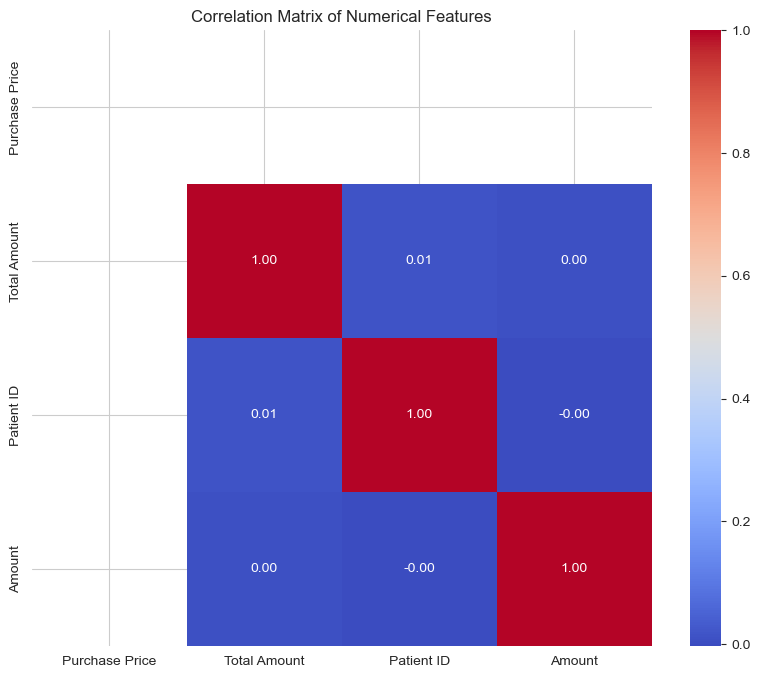

In [13]:
# Visualization 3: Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_cols = full_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = full_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [14]:
# ==============================================================================
# Step 5: Hypothesis Testing and Feature Engineering
# ==============================================================================

# Hypothesis Test: Are reimbursement amounts different for approved vs. denied claims?
approved_claims_amount = full_df[(full_df['Denied'] == False) & (full_df['Amount'].notna())]['Amount']
denied_claims_amount = full_df[(full_df['Denied'] == True) & (full_df['Amount'].notna())]['Amount']

t_stat, p_value = stats.ttest_ind(approved_claims_amount, denied_claims_amount, equal_var=False, nan_policy='omit')

print("\n--- Hypothesis Test: Approved vs. Denied Claim Amounts ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")


--- Hypothesis Test: Approved vs. Denied Claim Amounts ---
T-statistic: 0.0213
P-value: 0.9831


In [15]:
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: We reject the null hypothesis.")
    print("There is a statistically significant difference in reimbursement amounts.")
else:
    print("\nConclusion: We fail to reject the null hypothesis.")
    print("There is no statistically significant difference in reimbursement amounts.")


Conclusion: We fail to reject the null hypothesis.
There is no statistically significant difference in reimbursement amounts.


In [16]:
# Feature Engineering: Adding 'Profit Margin'
reimbursed_claims['Profit Margin'] = (reimbursed_claims['Profit'] / reimbursed_claims['Amount']) * 100

print("\n--- Feature Engineering: Profit Margin ---")
print("Top 5 Vials by Profit Margin:")
print(reimbursed_claims.nlargest(5, 'Profit Margin')[['Vial Number', 'Purchase Price', 'Amount', 'Profit', 'Profit Margin']])


--- Feature Engineering: Profit Margin ---
Top 5 Vials by Profit Margin:
      Vial Number  Purchase Price  Amount  Profit  Profit Margin
15     VN-0000010            50.0  199.98  149.98      74.997500
16     VN-0000011            50.0  199.98  149.98      74.997500
17     VN-0000012            50.0  199.98  149.98      74.997500
2695   VN-0002064            50.0  199.96  149.96      74.994999
13870  VN-0010556            50.0  199.94  149.94      74.992498


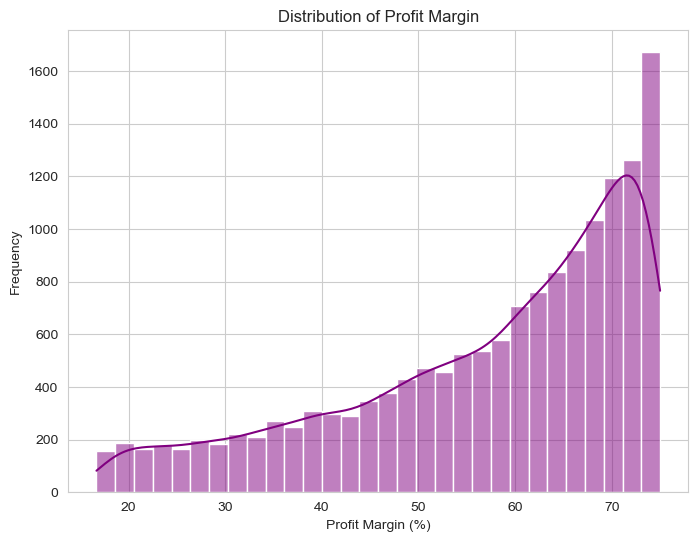

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(reimbursed_claims['Profit Margin'], kde=True, bins=30, color='purple')
plt.title('Distribution of Profit Margin')
plt.xlabel('Profit Margin (%)')
plt.ylabel('Frequency')
plt.show()

In [18]:
# ==============================================================================
# Step 6: Creating a Train-Test Split for Modeling
# ==============================================================================

print("\n--- Preparing Data for Modeling ---")

# 1. Defining the target variable (y)
# It will predict if a claim is denied (1) or not (0).
# Filling NaN with 0
full_df['Denied'] = full_df['Denied'].fillna(0).astype(int)
y = full_df['Denied'].astype(int)


--- Preparing Data for Modeling ---


In [19]:
# 2. Selecting features (X) to be used for prediction.
# Dropped identifiers and columns that are not useful for prediction.
features_to_use = full_df.drop(columns=[
    'Vial Number', 'Lot Number', 'Expiration Date', 'Invoice Number',
    'Invoice Date', 'Dispense ID', 'Patient ID', 'Date Of Dispense',
    'Claim ID', 'Claim Date', 'Denied', 'Unscanned'
])

In [20]:
# 3. One-hot encode the categorical features to convert them to numbers.
X = pd.get_dummies(features_to_use, drop_first=True)

In [21]:
# 4. Performed the Train-Test Split (80% train, 20% test)
# 'stratify=y' ensuring the proportion of denied claims is the same in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
# 5. Verified the split and show the shapes of the new datasets
print("\nData successfully split for modeling.")
print("--- Shape of the Datasets ---")
print(f"Training Features (X_train): {X_train.shape}")
print(f"Testing Features (X_test):  {X_test.shape}")
print(f"Training Target (y_train):    {y_train.shape}")
print(f"Testing Target (y_test):      {y_test.shape}")

print("\n--- Distribution of Target in Train vs. Test Sets ---")
print("Training Set (Denied=1):\n", y_train.value_counts(normalize=True))
print("\nTesting Set (Denied=1):\n", y_test.value_counts(normalize=True))

print("\n\n--- Conclution ---")
print("The datasets (X_train, X_test, y_train, y_test) are now ready for model building.")


Data successfully split for modeling.
--- Shape of the Datasets ---
Training Features (X_train): (12603, 9)
Testing Features (X_test):  (3151, 9)
Training Target (y_train):    (12603,)
Testing Target (y_test):      (3151,)

--- Distribution of Target in Train vs. Test Sets ---
Training Set (Denied=1):
 Denied
0    0.964374
1    0.035626
Name: proportion, dtype: float64

Testing Set (Denied=1):
 Denied
0    0.964456
1    0.035544
Name: proportion, dtype: float64


--- Conclution ---
The datasets (X_train, X_test, y_train, y_test) are now ready for model building.
